In [15]:
from cpclasses import *

In [16]:
class PhysicsInformed(torch.nn.Module):

    def __init__(self, N_hidden_depth=2, N_hidden_width=16):
        super().__init__()
        assert N_hidden_depth > 0, 'Must have at least one hidden layer'

        self.layers = torch.nn.Sequential(
            torch.nn.Linear(1, N_hidden_width),
            torch.nn.SiLU(),
            
                *[torch.nn.Linear(N_hidden_width, N_hidden_width), torch.nn.SiLU()] * (N_hidden_depth-1),
            torch.nn.Linear(N_hidden_width, 1)
         )

    def forward(self, x):
        return self.layers(x)

    def prediction_and_derivative(self, x):
        prediction = self.forward(x)
        derivative = torch.autograd.grad(prediction, x, torch.ones_like(prediction), create_graph=True)[0]

        return prediction, derivative



In [17]:
sigma = 0.5
x_00 = 1

PI = PhysicsInformed(N_hidden_depth=2, N_hidden_width=16)


criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(PI.parameters(), lr=0.001)
def train(x0, y0_target, epochs =2500, xmin=0, xmax = 5):

    x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
    y0_target = torch.tensor(y0_target, dtype=torch.float32)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        y0_predicted, _ = PI.prediction_and_derivative(x0)
        loss = criterion(y0_predicted, y0_target)

        xs = torch.rand((32,1), requires_grad=True) * (xmax - xmin) + xmin
        ys, dy_dxs = PI.prediction_and_derivative(xs)
        loss += 1/len(ys) * criterion(dy_dxs, ys * (x_00-xs)/sigma**2)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')


C:\Users\tobia\AppData\Local\Temp\ipykernel_1652\2274533682.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32, requires_grad=True)
C:\Users\tobia\AppData\Local\Temp\ipykernel_1652\2274533682.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y0_target = torch.tensor(y0_target, dtype=torch.float32)


Epoch 0, Loss: 2.204742908477783
Epoch 100, Loss: 0.9655359387397766
Epoch 200, Loss: 0.7791000604629517
Epoch 300, Loss: 0.717170238494873
Epoch 400, Loss: 0.7194253206253052
Epoch 500, Loss: 0.6743611097335815
Epoch 600, Loss: 0.5970103740692139
Epoch 700, Loss: 0.5986292362213135
Epoch 800, Loss: 0.6007215976715088
Epoch 900, Loss: 0.5462368130683899
Epoch 0, Loss: 0.5258699655532837
Epoch 100, Loss: 0.45180487632751465
Epoch 200, Loss: 0.5419997572898865
Epoch 300, Loss: 0.44761812686920166
Epoch 400, Loss: 0.4432890713214874
Epoch 500, Loss: 0.40881988406181335
Epoch 600, Loss: 0.30229997634887695
Epoch 700, Loss: 0.2945215702056885
Epoch 800, Loss: 0.24354267120361328
Epoch 900, Loss: 0.249576598405838
Epoch 0, Loss: 2.94403338432312
Epoch 100, Loss: 2.3201749324798584
Epoch 200, Loss: 0.9632076025009155
Epoch 300, Loss: 0.801098644733429
Epoch 400, Loss: 0.9513417482376099
Epoch 500, Loss: 0.8393257260322571
Epoch 600, Loss: 0.6310346126556396
Epoch 700, Loss: 0.6128862500190735

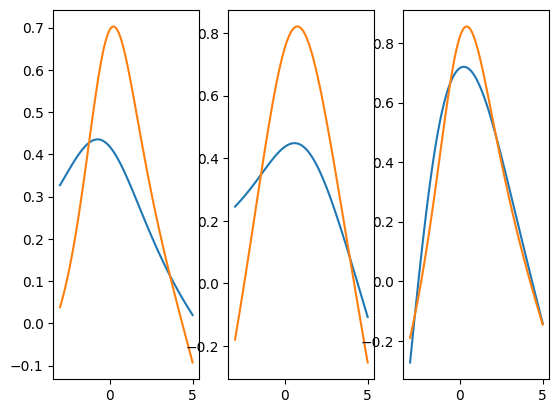

In [18]:
fig, axs = plt.subplots(1,3)

hidden = [1,1,2,2]
width = [2,4, 2,4]

for ax, h, w in zip(axs, hidden, width):
    PI = PhysicsInformed(N_hidden_depth=h, N_hidden_width=w)

    x_range = [-3, 5]
    xs_plot = torch.linspace(*x_range, 100, requires_grad=True).reshape(-1, 1)

    xsnp = xs_plot.detach().numpy()
    x0 = torch.zeros((1,1), requires_grad=True)
    y0_target = torch.ones((1,1))

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(PI.parameters(), lr=0.001)

    epoch_count = 0
    for epoch in [1000, 1000]:
        epoch_count += epoch
        train(x0, y0_target, epochs=epoch, xmin=x_range[0], xmax=x_range[1])
        ys, _ = PI.prediction_and_derivative(xs_plot)

        ax.plot(xsnp, ys.detach().numpy(), label=f'Epochs: {epoch_count}')    